<a href="https://colab.research.google.com/github/Anahi0504/practicas-finales-ml-u3-u4/blob/main/Copia_de_Random_Forests.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# En profundidad: Árboles de decisión y bosques aleatorios

Anteriormente hemos analizado en profundidad un clasificador generativo simple (naive Bayes; ver [En Profundidad: Clasificación Naive Bayes](05.05-Naive-Bayes.ipynb)) y un clasificador discriminativo poderoso (máquinas de vectores de soporte; ver [En Profundidad: Máquinas de Vectores de Soporte](05.07-Support-Vector-Machines.ipynb)).
Aquí veremos otro algoritmo poderoso: un algoritmo no paramétrico llamado *bosques aleatorios*.
Los bosques aleatorios son un ejemplo de un método de *conjunto*, lo que significa que se basa en agregar los resultados de un conjunto de estimadores más simples.
El resultado algo sorprendente con dichos métodos de conjunto es que la suma puede ser mayor que las partes: es decir, la precisión predictiva de un voto mayoritario entre varios estimadores puede terminar siendo mejor que la de cualquiera de los estimadores individuales que participan en la votación.
Veremos ejemplos de esto en las secciones siguientes.

Comenzamos con las importaciones estándar:

In [1]:
!pip install seaborn
import seaborn as sns

In [2]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
#plt.style.use('seaborn-whitegrid')
sns.set_style("whitegrid")

## Motivando los Bosques Aleatorios: Árboles de Decisión

Los bosques aleatorios son un ejemplo de un modelo de aprendizaje en conjunto construido a partir de árboles de decisión. Por esta razón, empezaremos por discutir los propios árboles de decisión.

Los árboles de decisión son formas extremadamente intuitivas de clasificar o etiquetar objetos: simplemente haces una serie de preguntas diseñadas para llegar a la clasificación. Por ejemplo, si quisieras construir un árbol de decisión para clasificar los animales que encuentras durante una caminata, podrías construir el que se muestra en la figura siguiente.

![](https://github.com/jakevdp/PythonDataScienceHandbook/blob/master/notebooks/images/05.08-decision-tree.png?raw=1)
[figure source in Appendix](https://github.com/jakevdp/PythonDataScienceHandbook/blob/master/notebooks/06.00-Figure-Code.ipynb#Decision-Tree-Example)

La división binaria hace que esto sea extremadamente eficiente: en un árbol bien construído, cada pregunta reducirá el número de opciones aproximadamente a la mitad, estrechando muy rápido las opciones incluso entre una gran cantidad de clases.  
El truco, por supuesto, está en decidir qué preguntas hacer en cada paso.  
En las implementaciones de árboles de decisión en aprendizaje automático, las preguntas generalmente toman la forma de divisiones alineadas con los ejes en los datos: es decir, cada nodo en el árbol divide los datos en dos grupos usando un valor de corte dentro de una de las características.  
Ahora veamos un ejemplo de esto.

### Creación de un Árbol de Decisión

Considera los siguientes datos bidimensionales, que tienen una de cuatro etiquetas de clase (ver la figura siguiente):

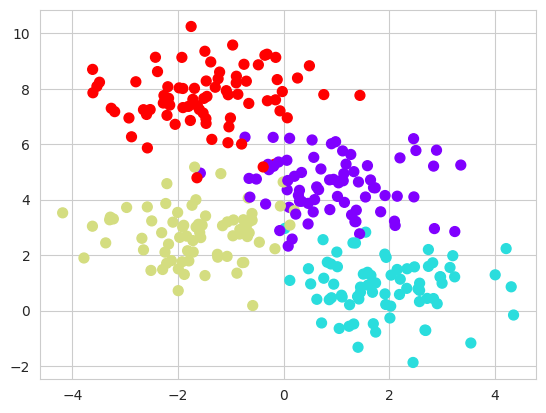

In [3]:
from sklearn.datasets import make_blobs

X, y = make_blobs(n_samples=300, centers=4,
                  random_state=0, cluster_std=1.0)
plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='rainbow');

Un árbol de decisión simple construido sobre estos datos irá dividiendo los datos de manera iterativa a lo largo de uno u otro eje según algún criterio cuantitativo, y en cada nivel asignará la etiqueta de la nueva región según el voto mayoritario de los puntos dentro de ella.
La siguiente figura presenta una visualización de los primeros cuatro niveles de un clasificador de árbol de decisión para estos datos.

![](https://github.com/jakevdp/PythonDataScienceHandbook/blob/master/notebooks/images/05.08-decision-tree-levels.png?raw=1)
[figure source in Appendix](https://github.com/jakevdp/PythonDataScienceHandbook/blob/master/notebooks/06.00-Figure-Code.ipynb#Decision-Tree-Levels)

Nota que después de la primera división, cada punto en la rama superior permanece sin cambios, por lo que no es necesario subdividir más esta rama.

Excepto por los nodos que contienen todo de un solo color, en cada nivel *toda* región se divide nuevamente según una de las dos características.

Este proceso de ajustar un árbol de decisiones a nuestros datos se puede realizar en Scikit-Learn con el estimador ``DecisionTreeClassifier``:

In [4]:
from sklearn.tree import DecisionTreeClassifier
tree = DecisionTreeClassifier().fit(X, y)

Vamos a escribir una función utilitaria para ayudarnos a visualizar la salida del clasificador:

In [5]:
def visualize_classifier(model, X, y, ax=None, cmap='rainbow'):
    ax = ax or plt.gca()

    # Graficar los puntos de entrenamiento
    ax.scatter(X[:, 0], X[:, 1], c=y, s=30, cmap=cmap,
               clim=(y.min(), y.max()), zorder=3)
    ax.axis('tight')
    ax.axis('off')
    xlim = ax.get_xlim()
    ylim = ax.get_ylim()

    # ajustar el estimador
    model.fit(X, y)
    xx, yy = np.meshgrid(np.linspace(*xlim, num=200),
                         np.linspace(*ylim, num=200))
    Z = model.predict(np.c_[xx.ravel(), yy.ravel()]).reshape(xx.shape)

    # Crear un gráfico de colores con los resultados
    n_classes = len(np.unique(y))
    contours = ax.contourf(xx, yy, Z, alpha=0.3,
                           levels=np.arange(n_classes + 1) - 0.5,
                           cmap=cmap, zorder=1)

    ax.set(xlim=xlim, ylim=ylim)

Ahora podemos examinar cómo se ve la clasificación del árbol de decisión (ver la figura siguiente):

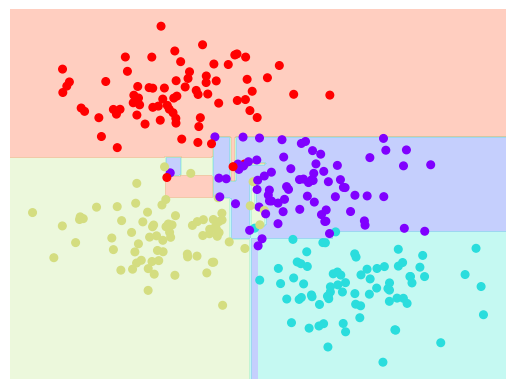

In [6]:
visualize_classifier(DecisionTreeClassifier(), X, y)

In [7]:

import helpers
helpers.plot_tree_interactive(X, y);

ModuleNotFoundError: No module named 'ipywidgets'

Observa que a medida que aumenta la profundidad, tendemos a obtener regiones de clasificación de formas muy extrañas; por ejemplo, a una profundidad de cinco, hay una región morada alta y delgada entre las regiones amarilla y azul.
Está claro que esto se debe menos a la verdadera distribución intrínseca de los datos y más a las propiedades particulares de muestreo o ruido de los datos.
Es decir, este árbol de decisión, incluso con solo cinco niveles de profundidad, claramente está sobreajustando nuestros datos.

### Árboles de Decisión y Sobreajuste

Este sobreajuste resulta ser una propiedad general de los árboles de decisión: es muy fácil profundizar demasiado en el árbol y, por lo tanto, ajustar los detalles de los datos específicos en lugar de las propiedades generales de las distribuciones de las que provienen.
Otra forma de observar este sobreajuste es mirar modelos entrenados con diferentes subconjuntos de los datos; por ejemplo, en esta figura entrenamos dos árboles diferentes, cada uno con la mitad de los datos originales.

![](https://github.com/jakevdp/PythonDataScienceHandbook/blob/master/notebooks/images/05.08-decision-tree-overfitting.png?raw=1)
[figure source in Appendix](https://github.com/jakevdp/PythonDataScienceHandbook/blob/master/notebooks/06.00-Figure-Code.ipynb#Decision-Tree-Overfitting)

Está claro que en algunos lugares los dos árboles producen resultados consistentes (por ejemplo, en las cuatro esquinas), mientras que en otros lugares los dos árboles dan clasificaciones muy diferentes (por ejemplo, en las regiones entre cualquier par de clusters).
La observación clave es que las inconsistencias tienden a ocurrir donde la clasificación es menos segura, y por lo tanto, al usar la información de *ambos* árboles, ¡podríamos obtener un mejor resultado!

Si estás ejecutando este cuaderno en vivo, la siguiente función te permitirá mostrar de manera interactiva los ajustes de los árboles entrenados en un subconjunto aleatorio de los datos:

In [ ]:
# helpers_05_08 se encuentra en el apéndice en línea
import helpers
helpers.randomized_tree_interactive(X, y)

interactive(children=(IntSlider(value=0, description='random_state'), Output()), _dom_classes=('widget-interac…

Así como usar información de dos árboles mejora nuestros resultados, podríamos esperar que usar información de muchos árboles mejore nuestros resultados aún más.

## Conjuntos de Estimadores: Bosques Aleatorios

Esta noción —que varios estimadores que sobreajustan pueden combinarse para reducir el efecto de este sobreajuste— es la base de un método de conjunto llamado *bagging*.
El bagging utiliza un conjunto (una especie de mezcla, tal vez) de estimadores paralelos, cada uno de los cuales sobreajusta los datos, y promedia los resultados para encontrar una mejor clasificación.
Un conjunto de árboles de decisión aleatorios se conoce como *bosque aleatorio*.

Este tipo de clasificación por bagging se puede realizar manualmente usando el meta-estimador `BaggingClassifier` de Scikit-Learn, como se muestra aquí (ver la siguiente figura):

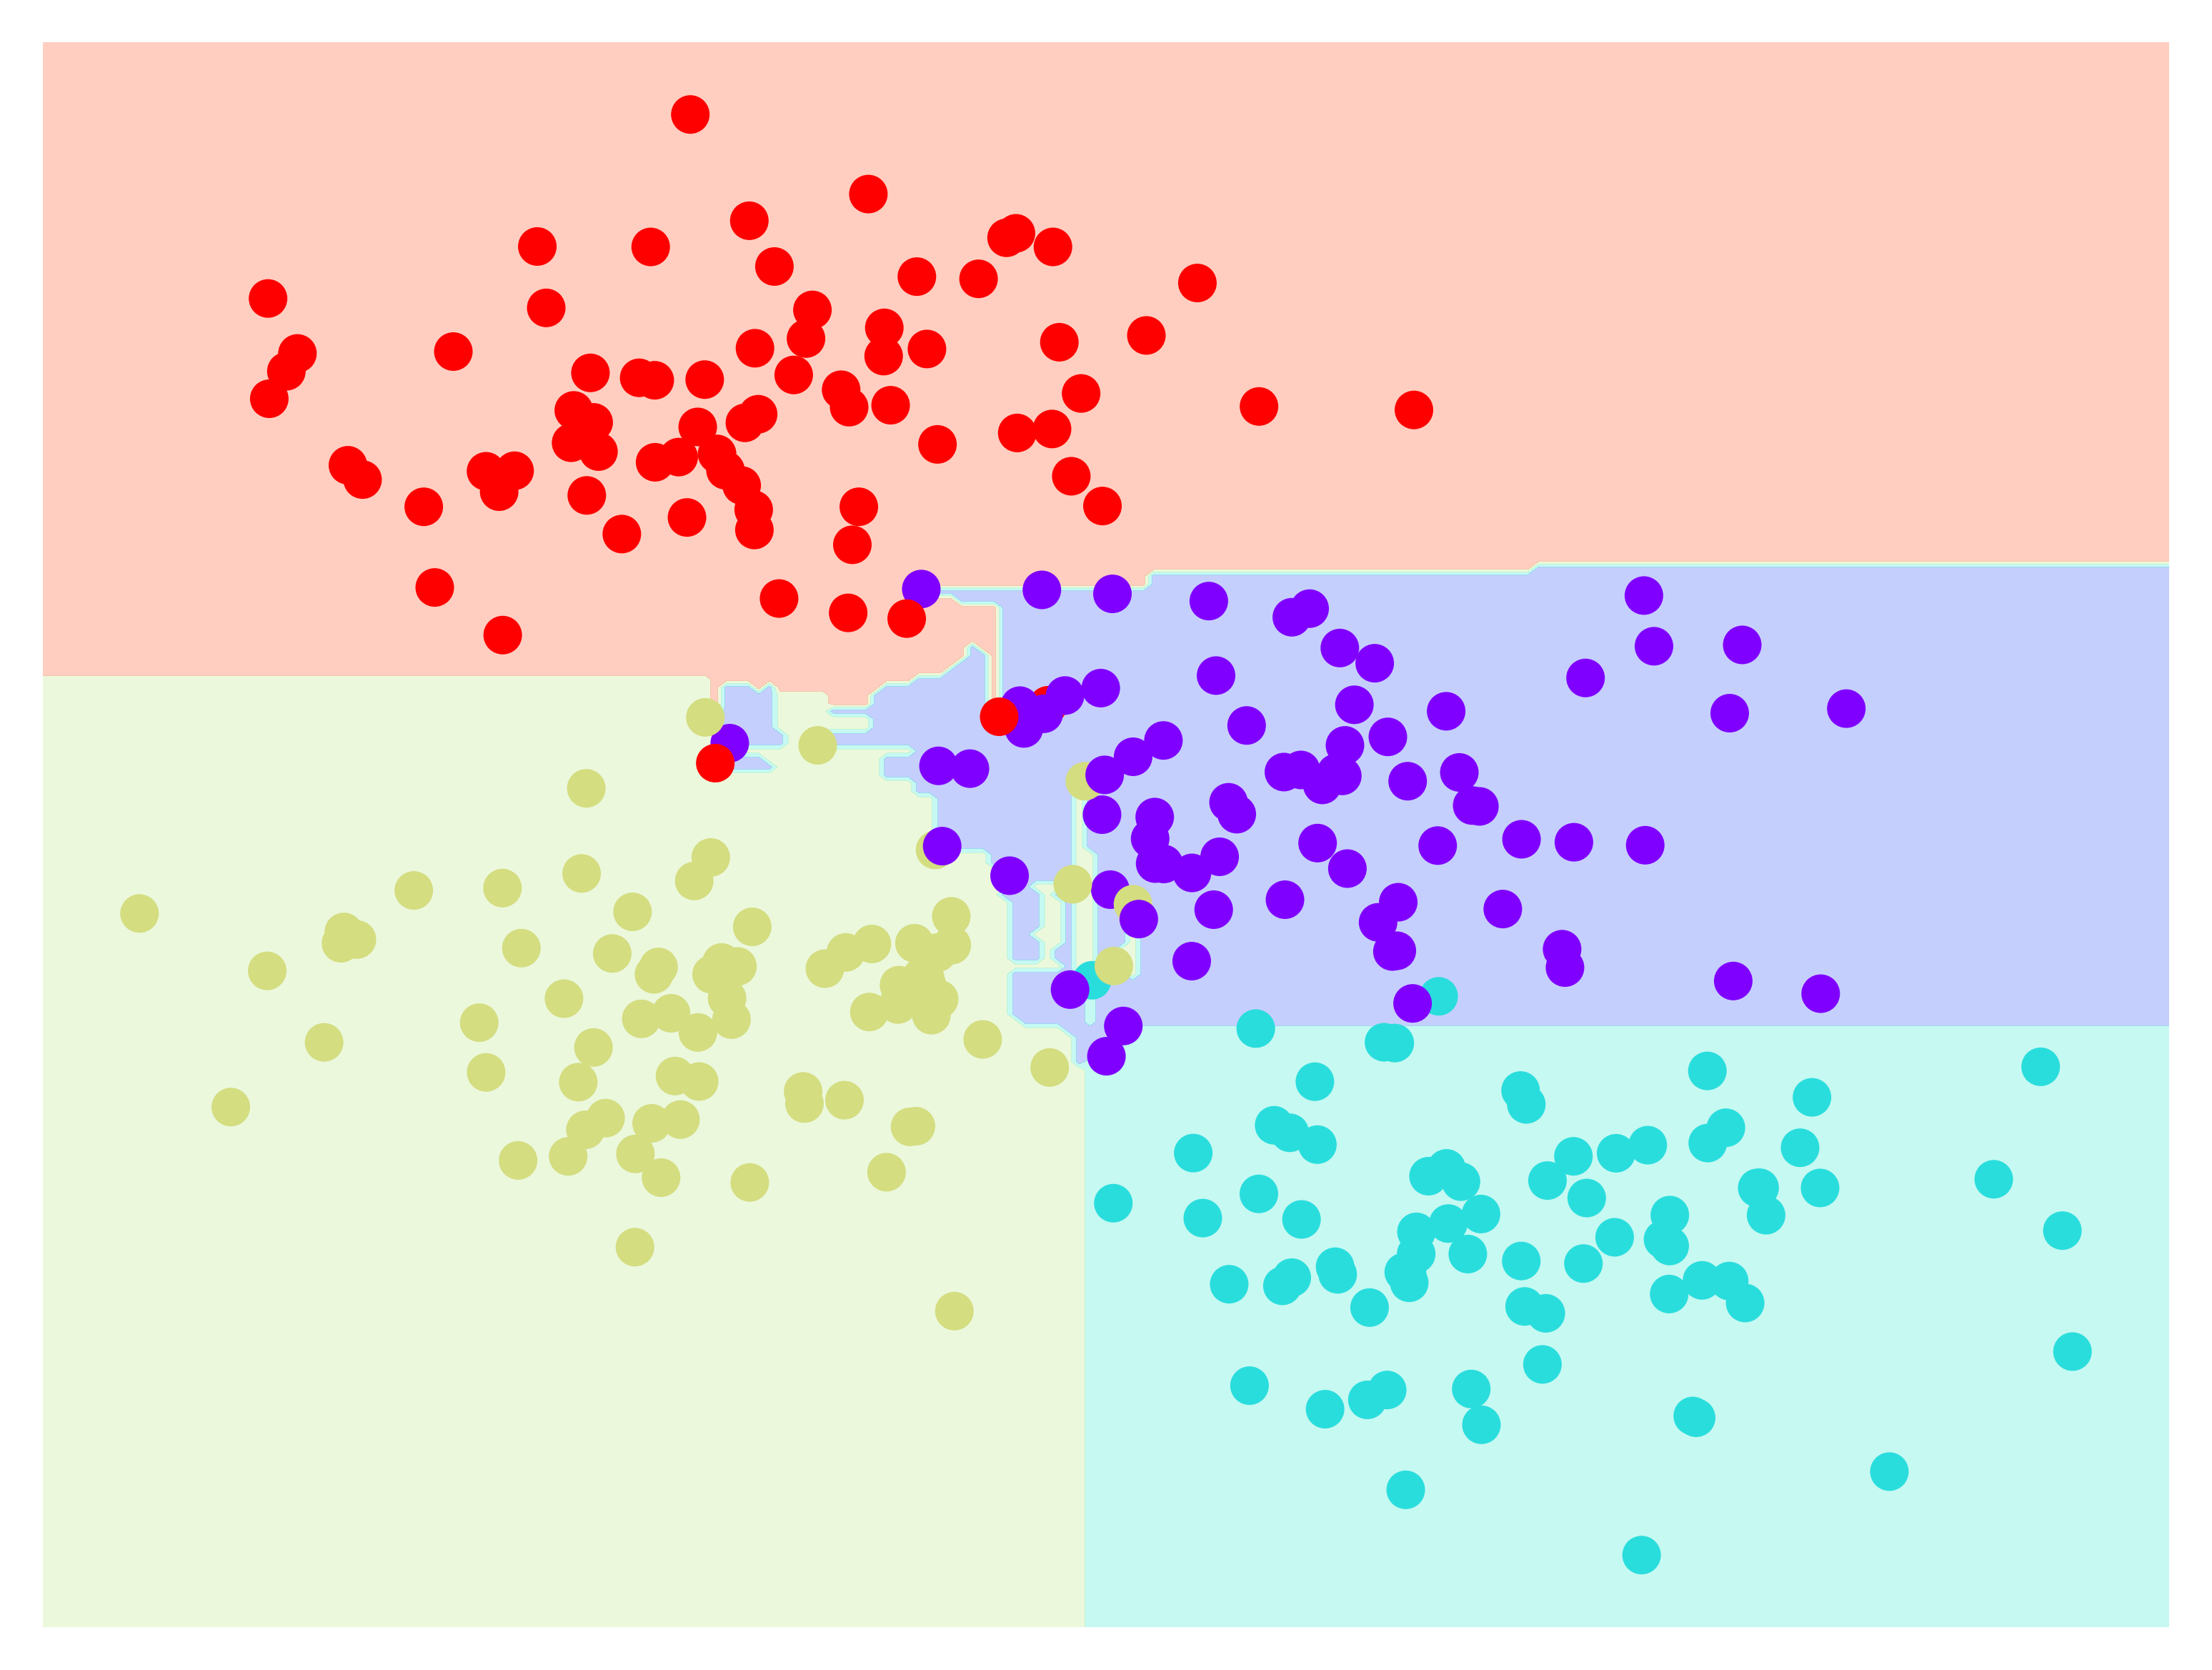

In [ ]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier

tree = DecisionTreeClassifier()
bag = BaggingClassifier(tree, n_estimators=100, max_samples=0.8,
                        random_state=1)

bag.fit(X, y)
visualize_classifier(bag, X, y)

En este ejemplo, hemos aleatorizado los datos ajustando cada estimador con un subconjunto aleatorio del 80% de los puntos de entrenamiento.
En la práctica, los árboles de decisión se aleatorizan de manera más efectiva al introducir cierta aleatoriedad en cómo se eligen las divisiones: de esta manera, todos los datos contribuyen al ajuste cada vez, pero los resultados del ajuste aún tienen la aleatoriedad deseada.
Por ejemplo, al determinar qué característica usar para dividir, el árbol aleatorizado podría seleccionar entre las principales características. Puedes leer más detalles técnicos sobre estas estrategias de aleatorización en la [documentación de Scikit-Learn](http://scikit-learn.org/stable/modules/ensemble.html#forest) y en las referencias allí incluidas.

En Scikit-Learn, un conjunto optimizado de árboles de decisión aleatorizados está implementado en el estimador `RandomForestClassifier`, que se encarga de toda la aleatorización automáticamente.
Todo lo que necesitas hacer es seleccionar un número de estimadores, y se ajustará muy rápidamente, en paralelo si se desea, el conjunto de árboles (ver la figura siguiente):

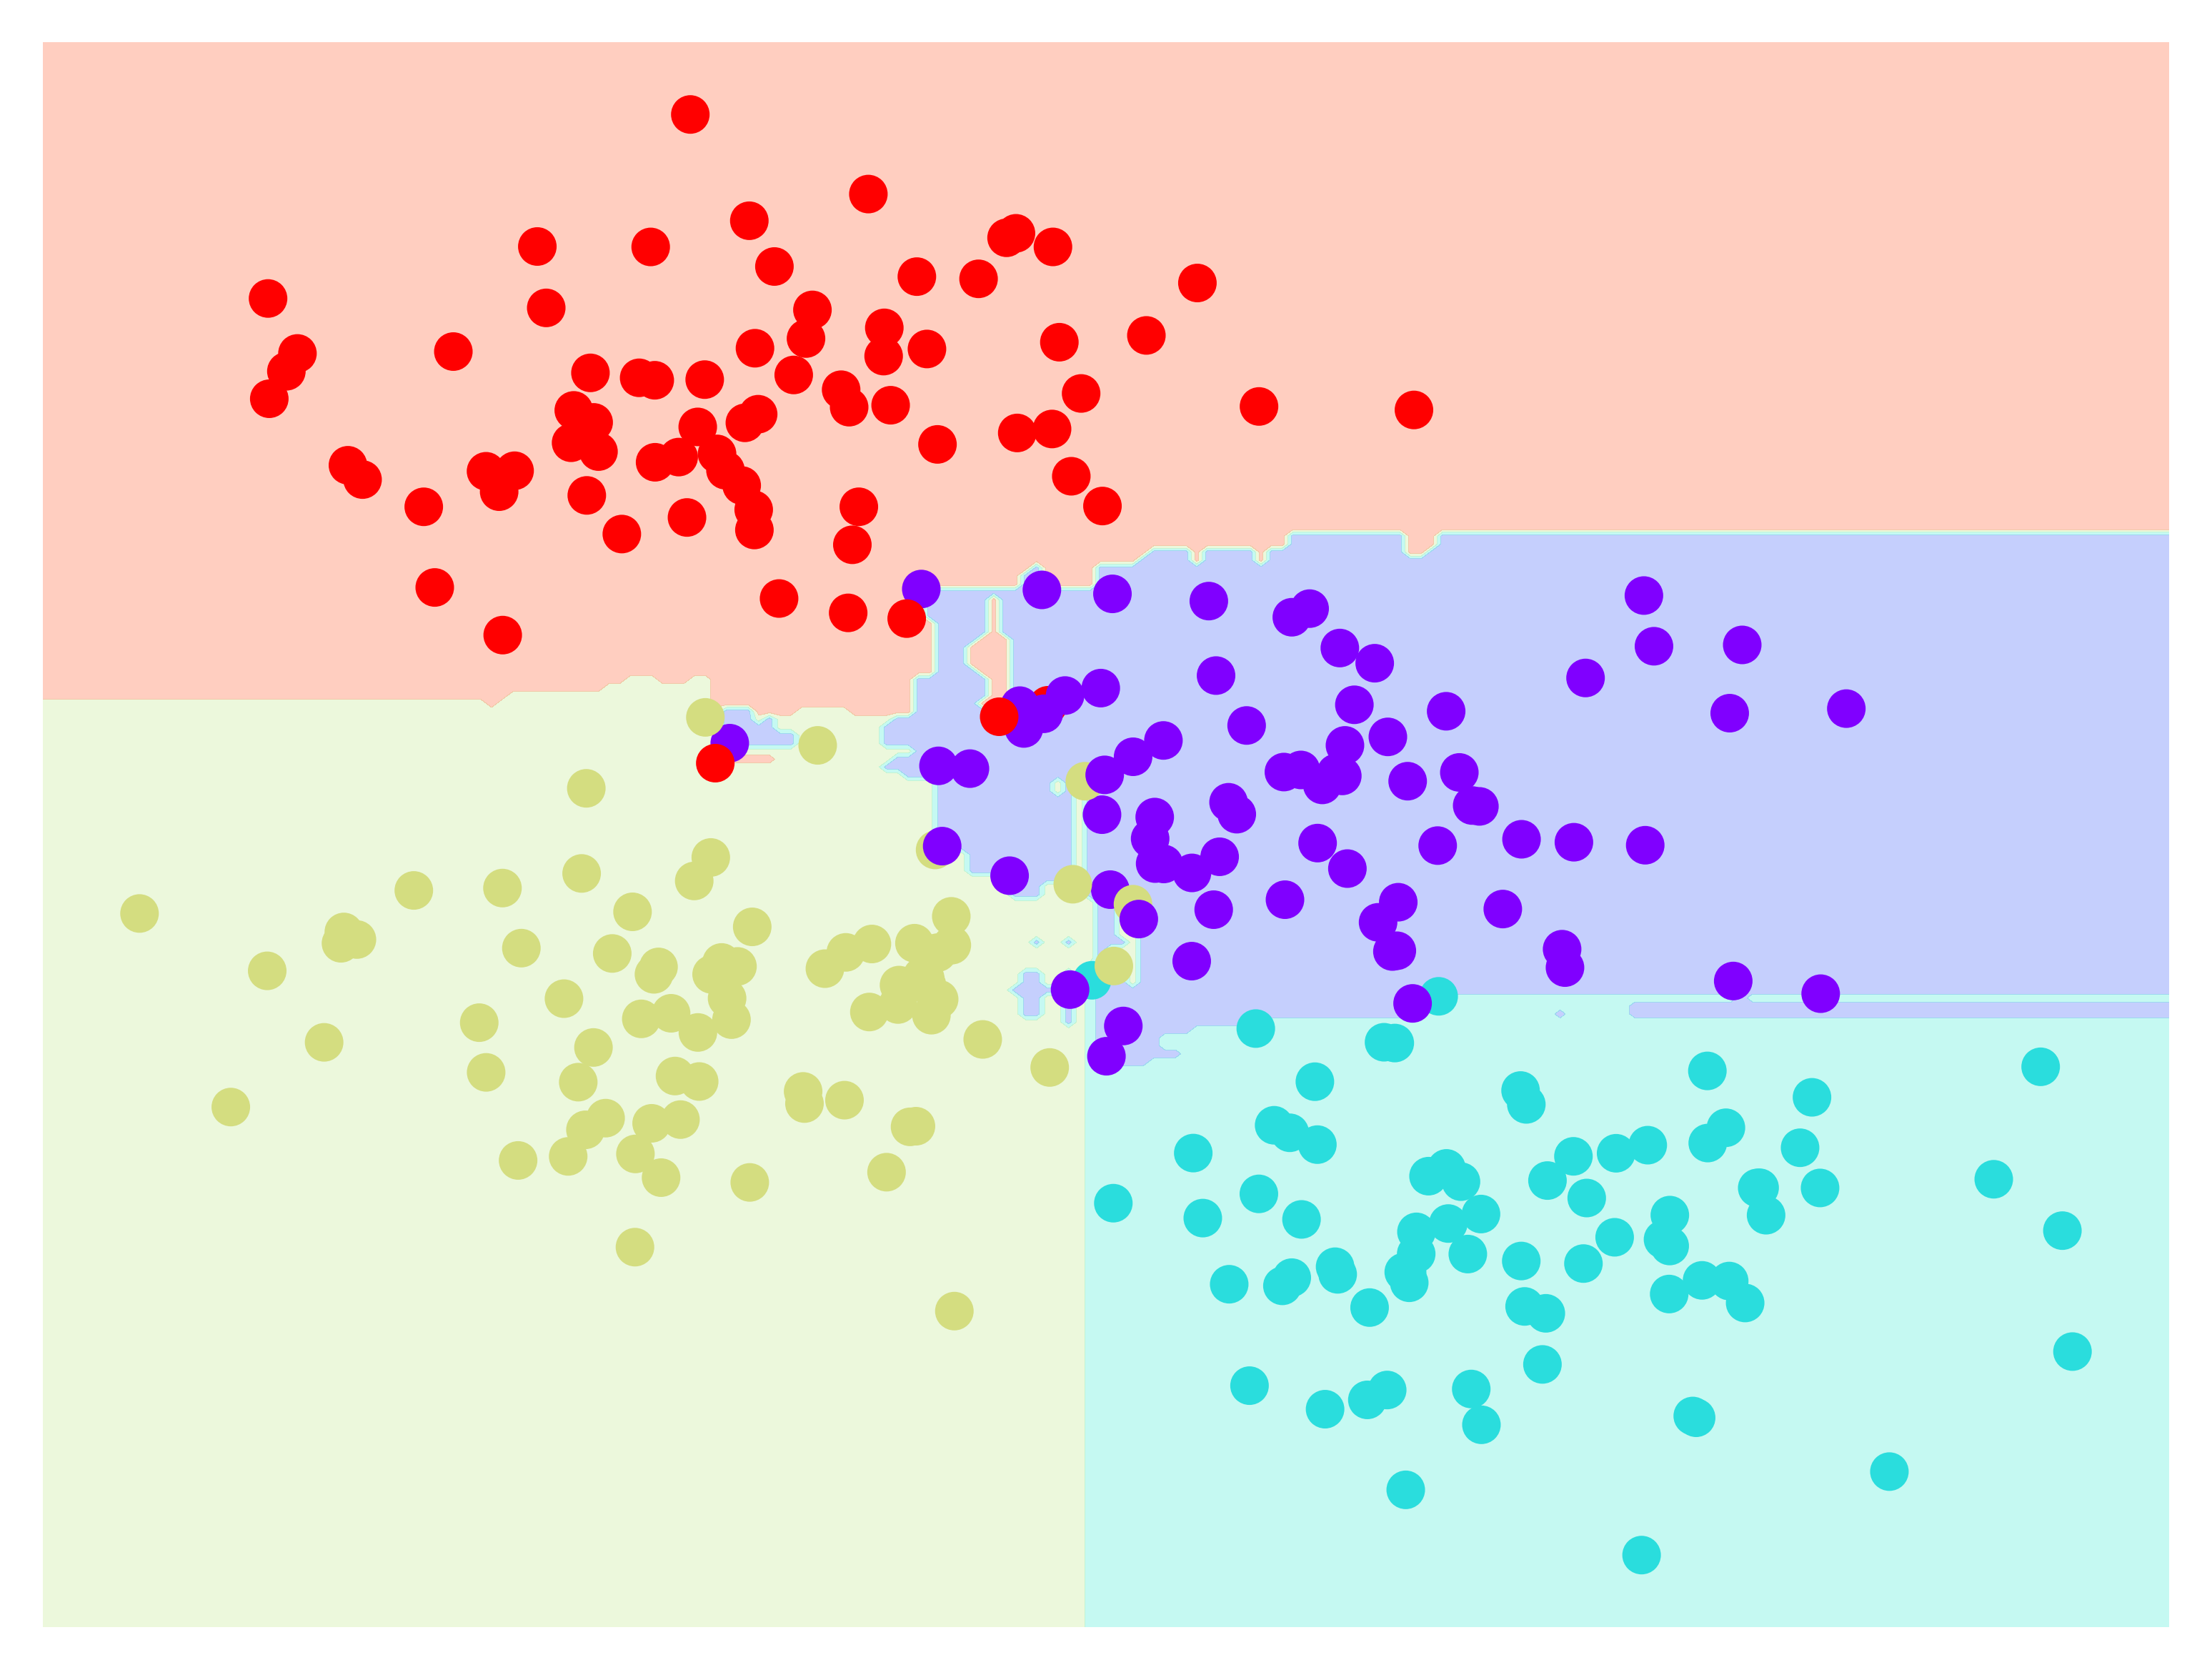

In [ ]:
from sklearn.ensemble import RandomForestClassifier

model = RandomForestClassifier(n_estimators=100, random_state=0)
visualize_classifier(model, X, y);

Vemos que al promediar sobre 100 modelos perturbados aleatoriamente, terminamos con un modelo general que está mucho más cerca de nuestra intuición sobre cómo debería dividirse el espacio de parámetros.

## Regresión con Bosques Aleatorios

En la sección anterior consideramos los bosques aleatorios en el contexto de la clasificación. Los bosques aleatorios también pueden aplicarse en el caso de la regresión (es decir, con variables continuas en lugar de categóricas). El estimador a utilizar para esto es el `RandomForestRegressor`, y la sintaxis es muy similar a la que vimos anteriormente.

Consideremos los siguientes datos, obtenidos a partir de la combinación de una oscilación rápida y una lenta (ver la figura siguiente):

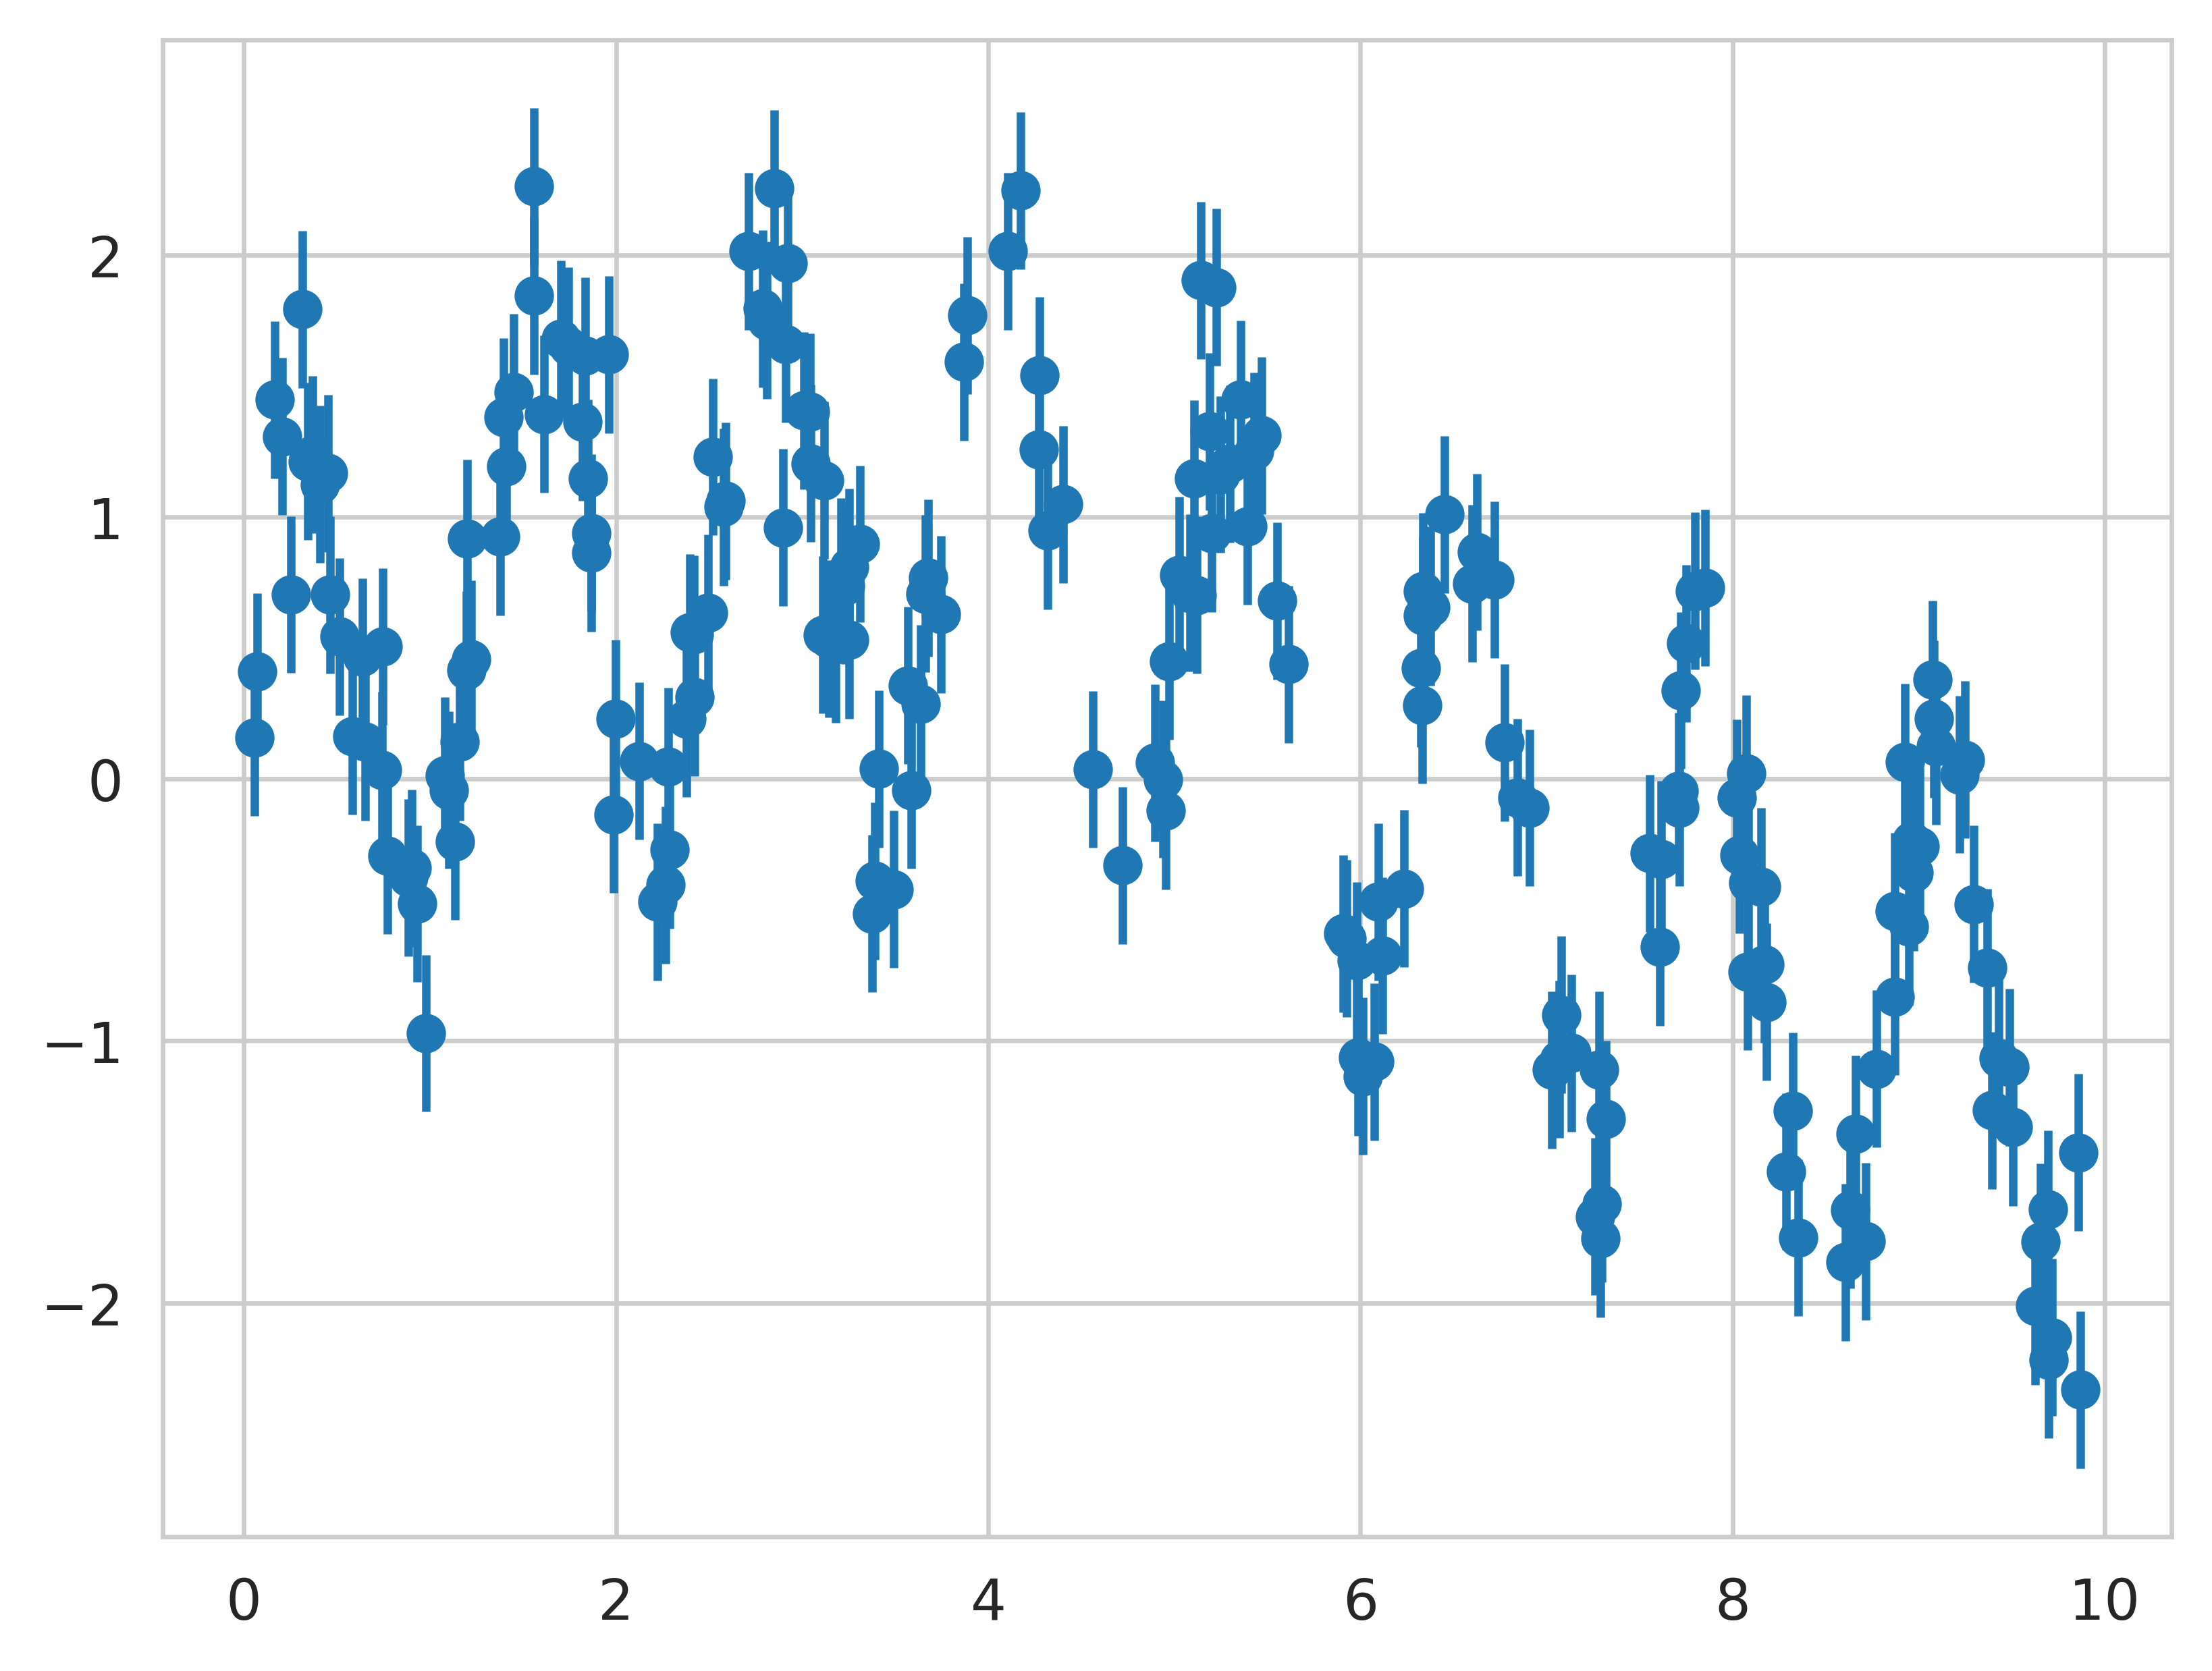

In [ ]:
rng = np.random.RandomState(42)
x = 10 * rng.rand(200)

def model(x, sigma=0.3):
    fast_oscillation = np.sin(5 * x)
    slow_oscillation = np.sin(0.5 * x)
    noise = sigma * rng.randn(len(x))

    return slow_oscillation + fast_oscillation + noise

y = model(x)
plt.errorbar(x, y, 0.3, fmt='o');

Usando el regresor de bosque aleatorio, podemos encontrar la curva de mejor ajuste de la siguiente manera (ver la figura siguiente):

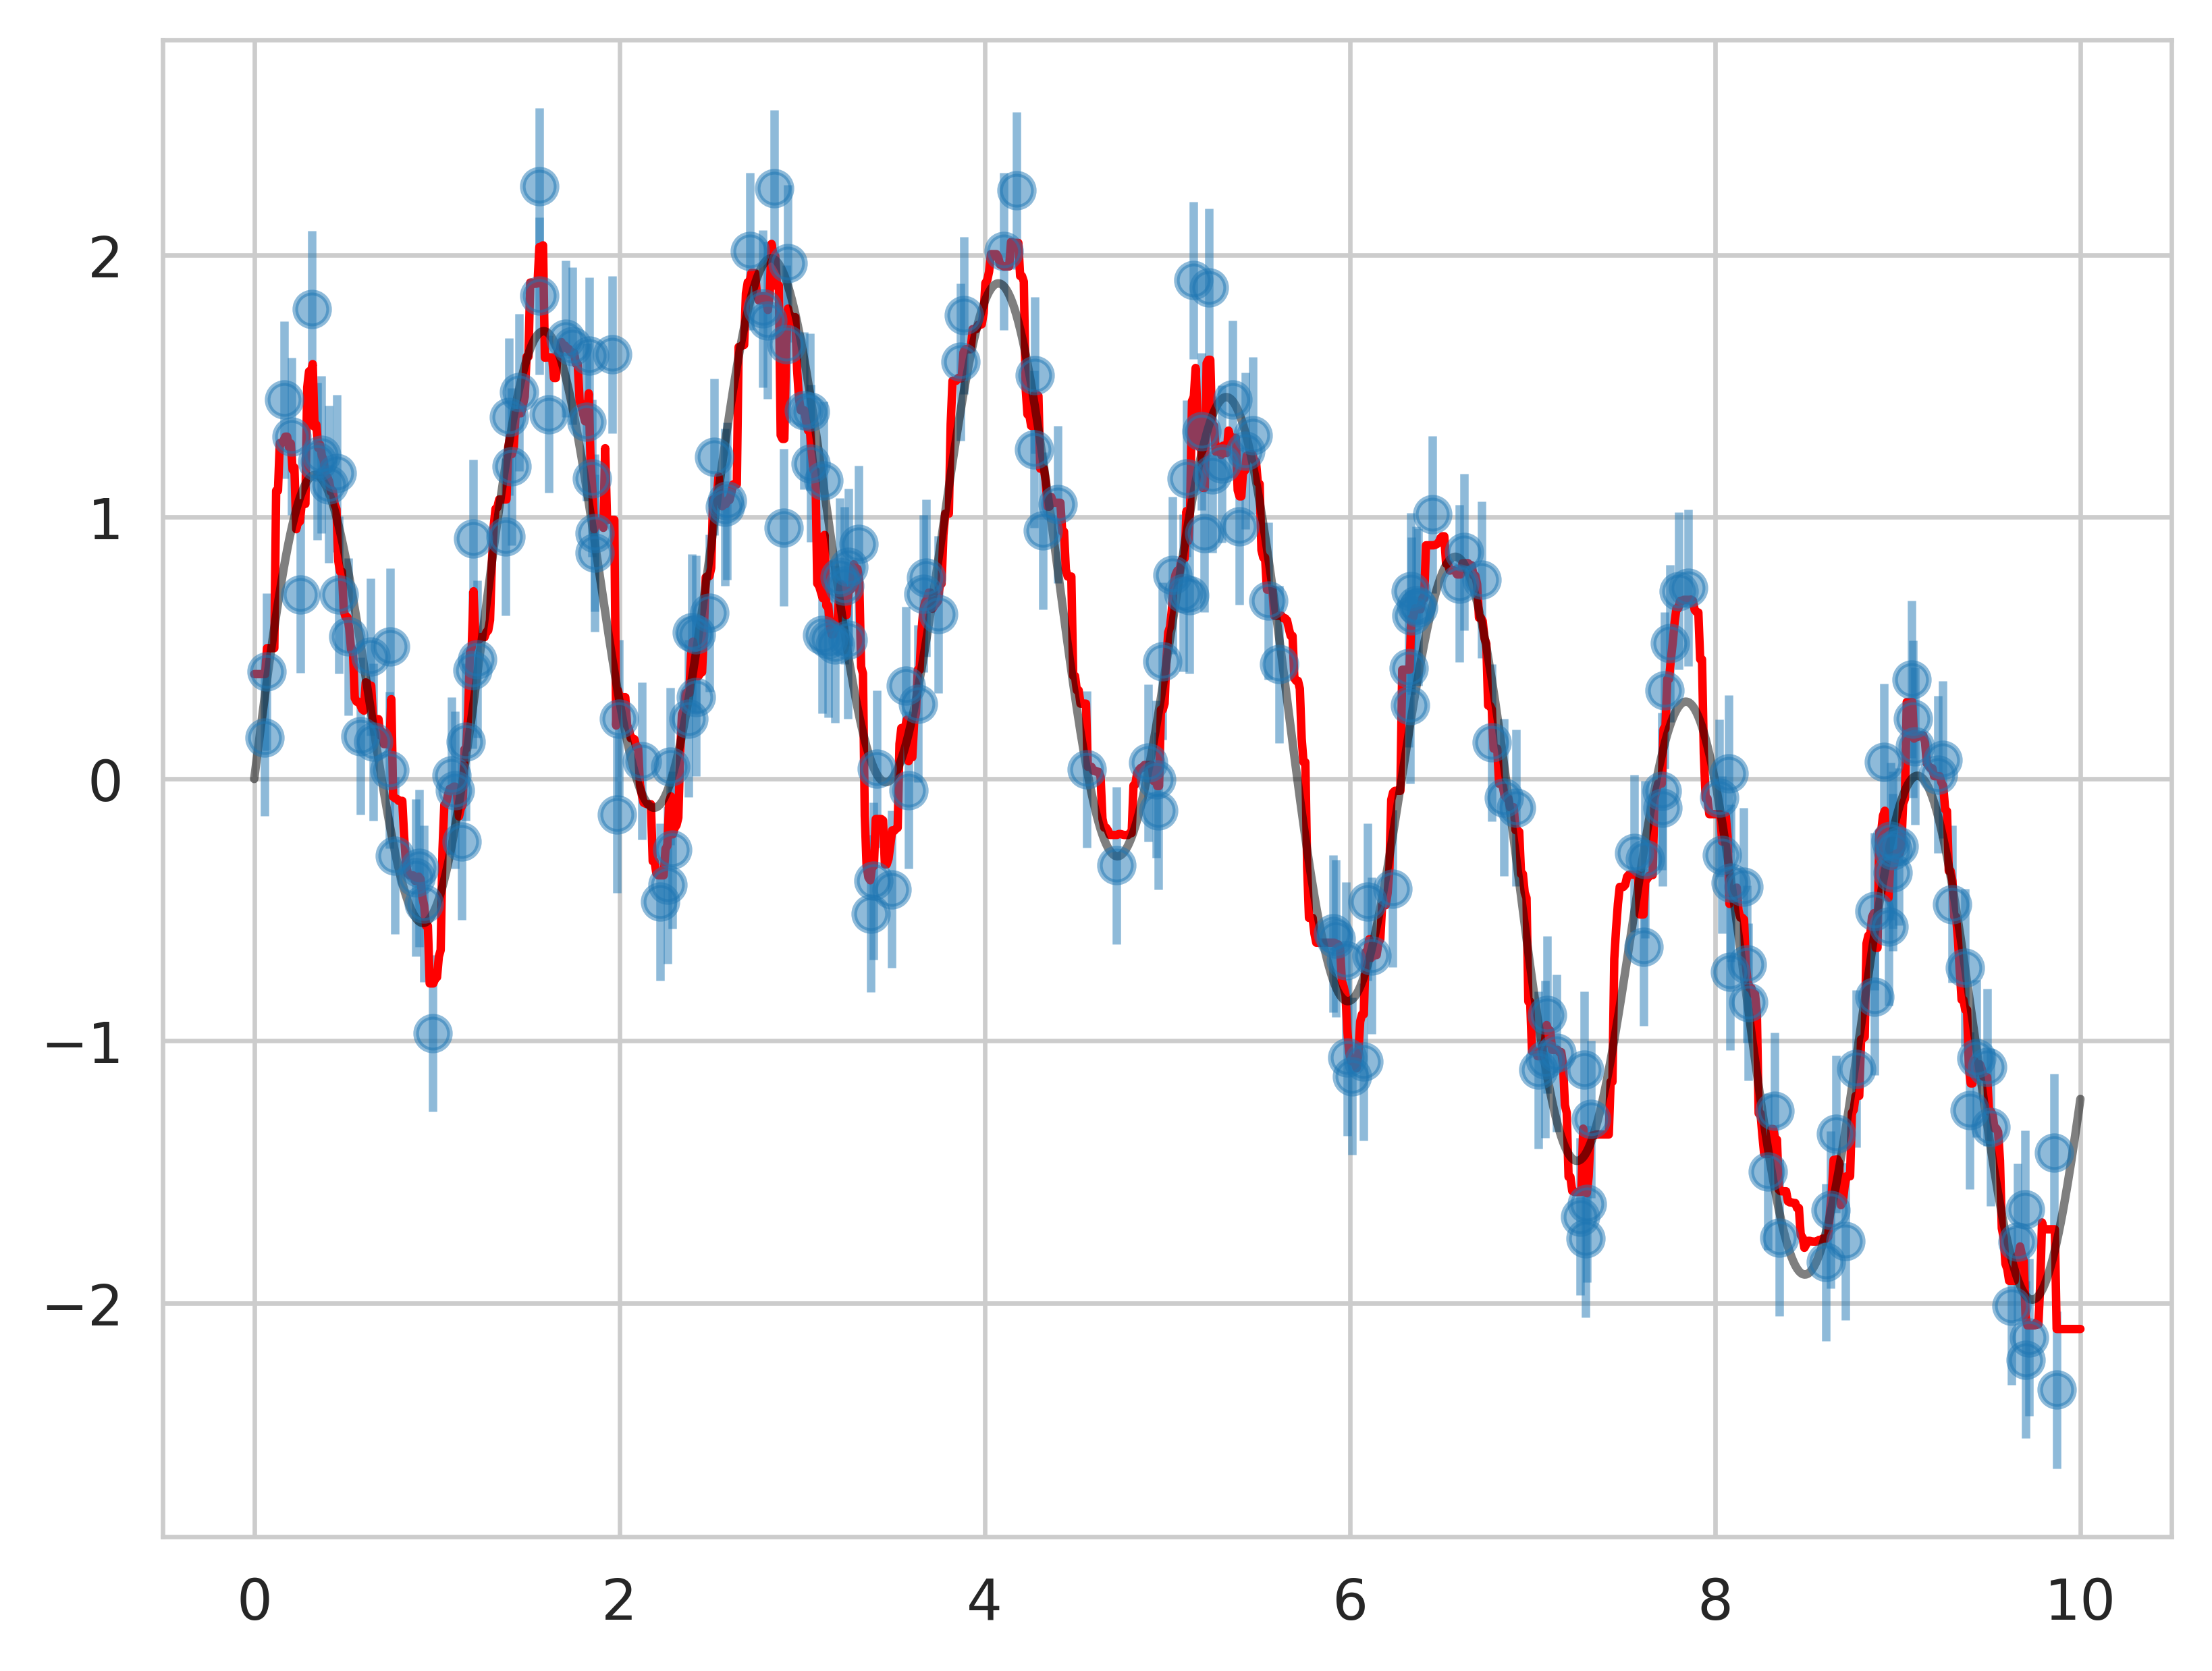

In [ ]:
from sklearn.ensemble import RandomForestRegressor
forest = RandomForestRegressor(200)
forest.fit(x[:, None], y)

xfit = np.linspace(0, 10, 1000)
yfit = forest.predict(xfit[:, None])
ytrue = model(xfit, sigma=0)

plt.errorbar(x, y, 0.3, fmt='o', alpha=0.5)
plt.plot(xfit, yfit, '-r');
plt.plot(xfit, ytrue, '-k', alpha=0.5);

Aquí se muestra el modelo verdadero en la curva gris suave, mientras que el modelo de bosque aleatorio se muestra con la curva roja dentada. El modelo no paramétrico de bosque aleatorio es lo suficientemente flexible para ajustarse a los datos multiperiodo, ¡sin que necesitemos especificar un modelo multiperiodo!

## Ejemplo: Bosque Aleatorio para Clasificar Dígitos

En el Capítulo 38 trabajamos con un ejemplo usando el conjunto de datos de dígitos incluido con Scikit-Learn.
Usemos eso nuevamente aquí para ver cómo se puede aplicar el clasificador de bosque aleatorio en este contexto:

In [ ]:
from sklearn.datasets import load_digits
digits = load_digits()
digits.keys()

dict_keys(['data', 'target', 'frame', 'feature_names', 'target_names', 'images', 'DESCR'])

Para recordarnos lo que estamos observando, visualizaremos los primeros puntos de datos (ver la siguiente figura):

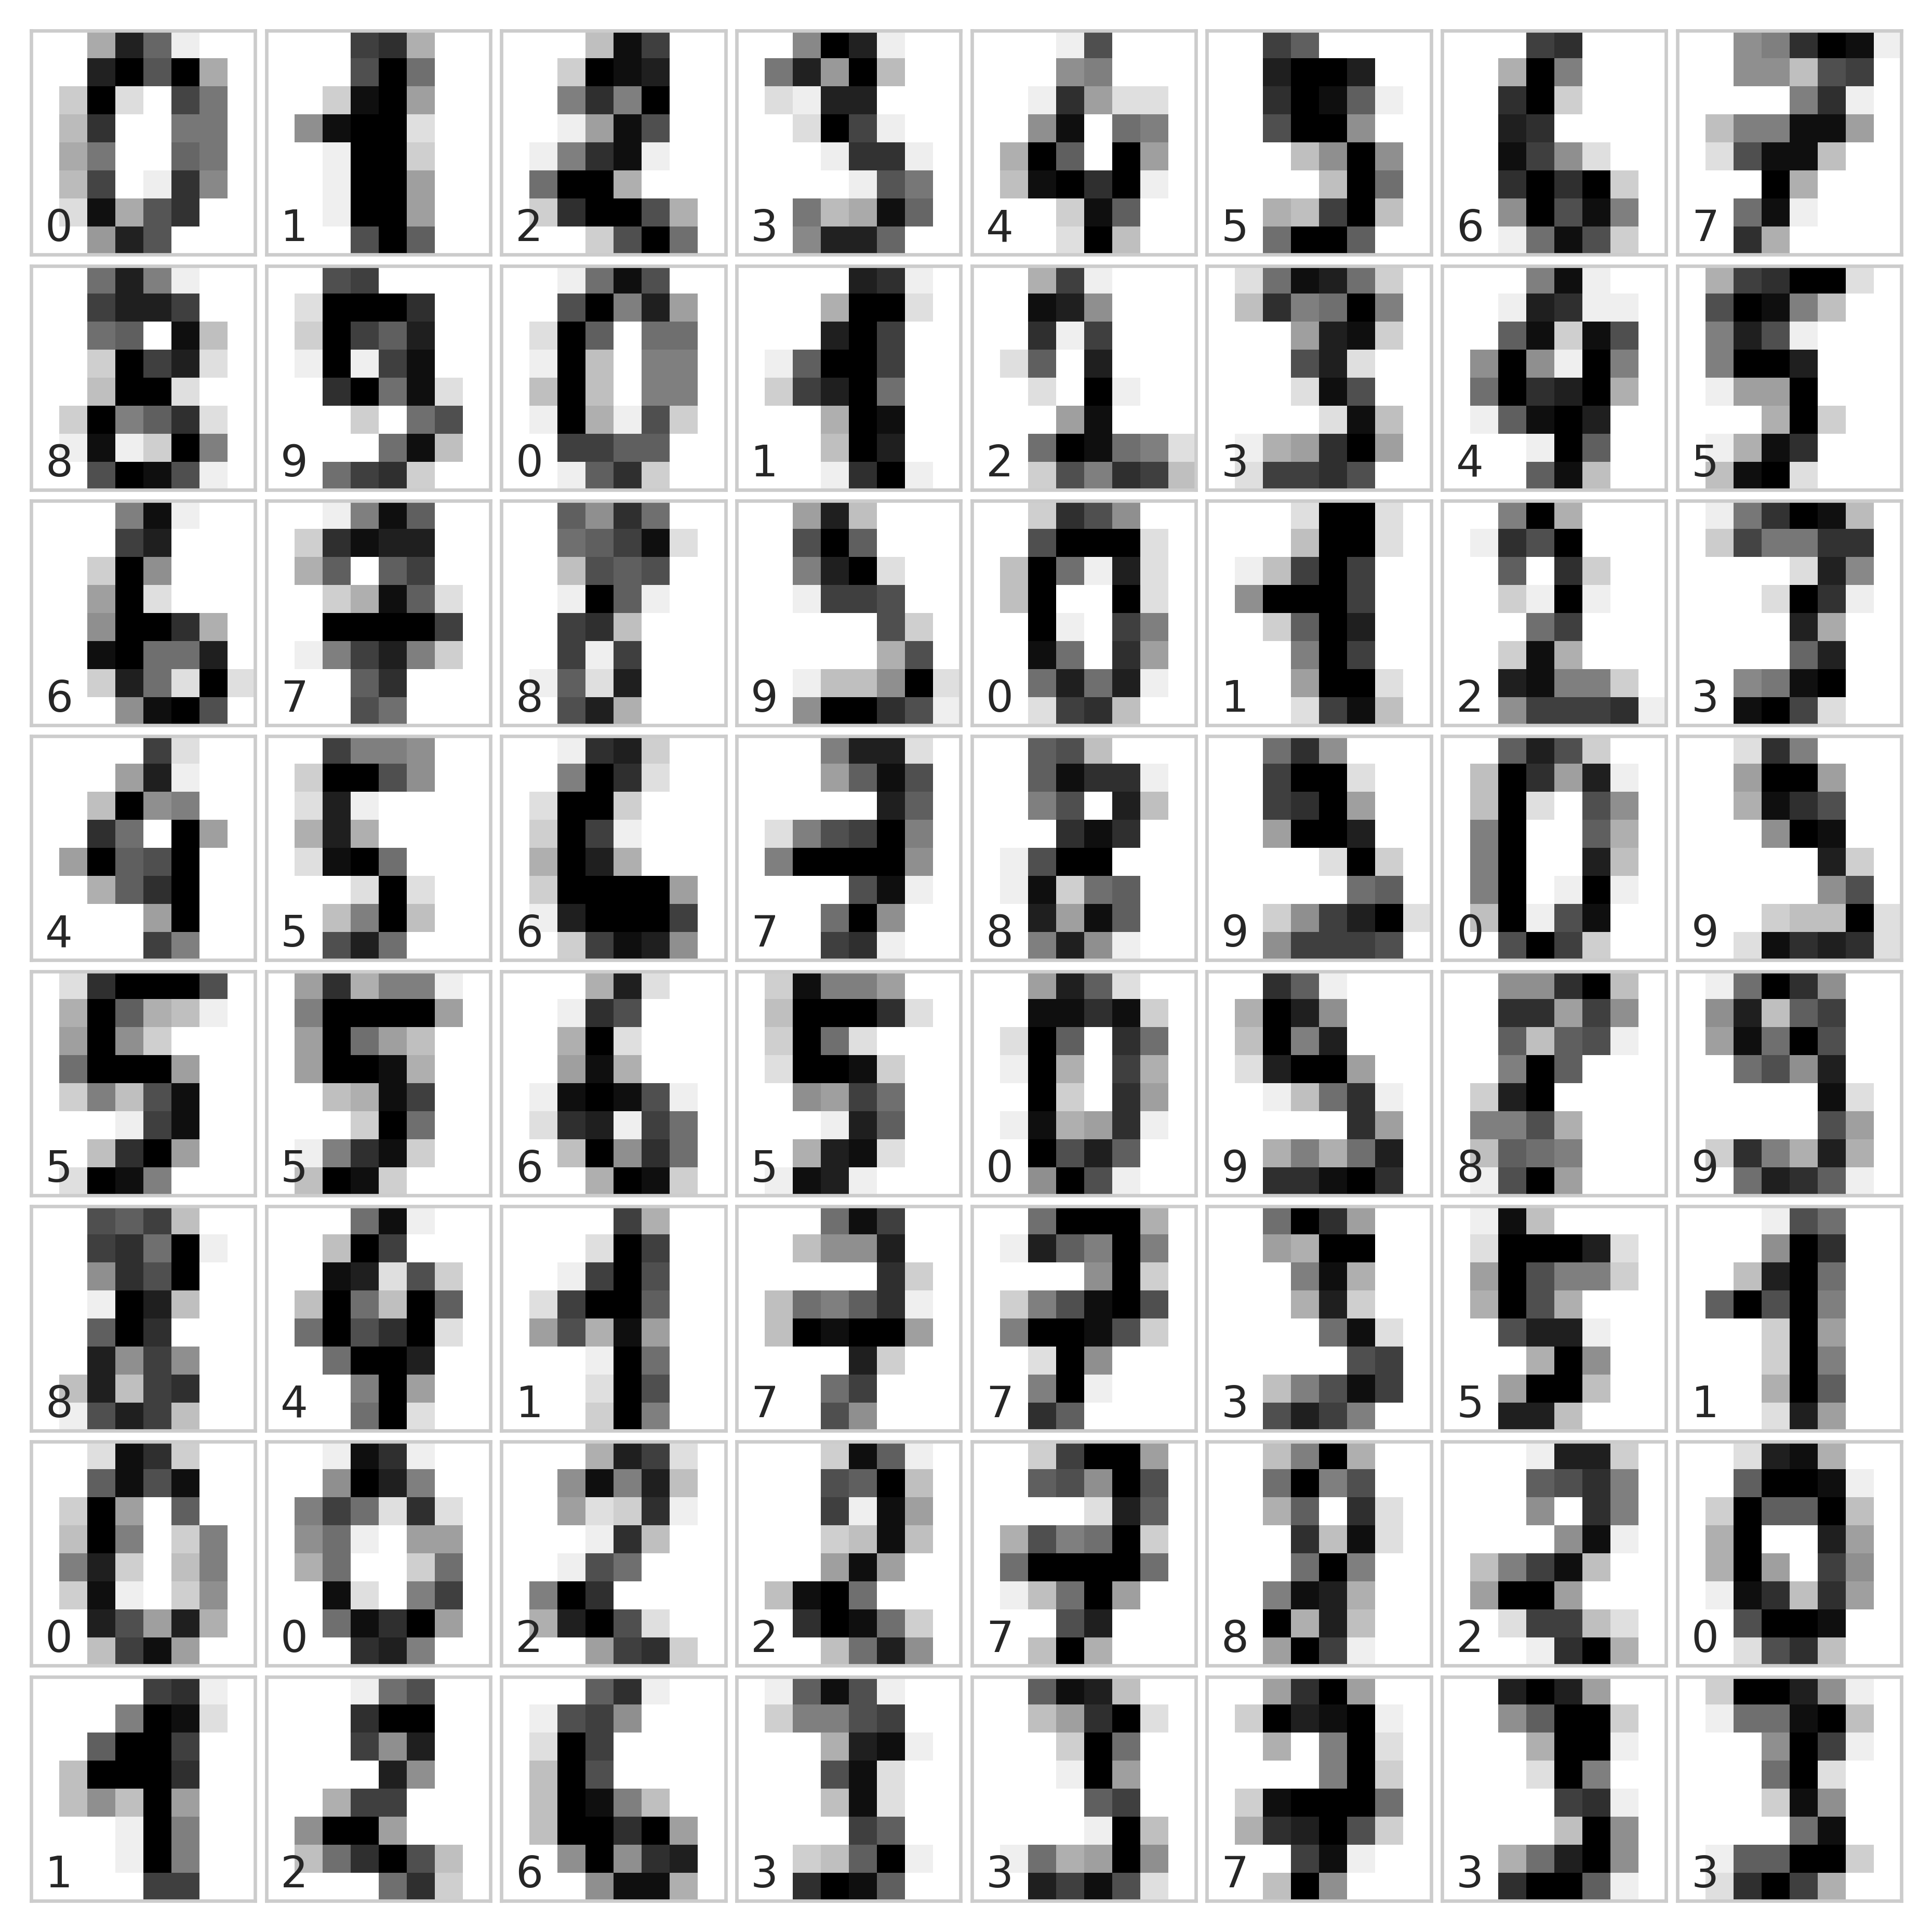

In [ ]:
# configurar la figura
fig = plt.figure(figsize=(6, 6))  # tamaño de la figura en pulgadas
fig.subplots_adjust(left=0, right=1, bottom=0, top=1, hspace=0.05, wspace=0.05)

# trazar los dígitos: cada imagen tiene 8x8 píxeles
for i in range(64):
    ax = fig.add_subplot(8, 8, i + 1, xticks=[], yticks=[])
    ax.imshow(digits.images[i], cmap=plt.cm.binary, interpolation='nearest')

    # etiquetar la imagen con el valor objetivo
    ax.text(0, 7, str(digits.target[i]))

Podemos clasificar los dígitos usando un bosque aleatorio de la siguiente manera:

In [ ]:
from sklearn.model_selection import train_test_split

Xtrain, Xtest, ytrain, ytest = train_test_split(digits.data, digits.target,
                                                random_state=0)
model = RandomForestClassifier(n_estimators=1000)
model.fit(Xtrain, ytrain)
ypred = model.predict(Xtest)

Veamos el informe de clasificación de este clasificador:

In [ ]:
from sklearn import metrics
print(metrics.classification_report(ypred, ytest))

              precision    recall  f1-score   support

           0       1.00      0.97      0.99        38
           1       0.98      0.98      0.98        43
           2       0.95      1.00      0.98        42
           3       0.98      0.96      0.97        46
           4       0.97      1.00      0.99        37
           5       0.98      0.96      0.97        49
           6       1.00      1.00      1.00        52
           7       1.00      0.96      0.98        50
           8       0.94      0.98      0.96        46
           9       0.98      0.98      0.98        47

    accuracy                           0.98       450
   macro avg       0.98      0.98      0.98       450
weighted avg       0.98      0.98      0.98       450



Y para mayor seguridad, grafique la matriz de confusión (ver la siguiente figura):

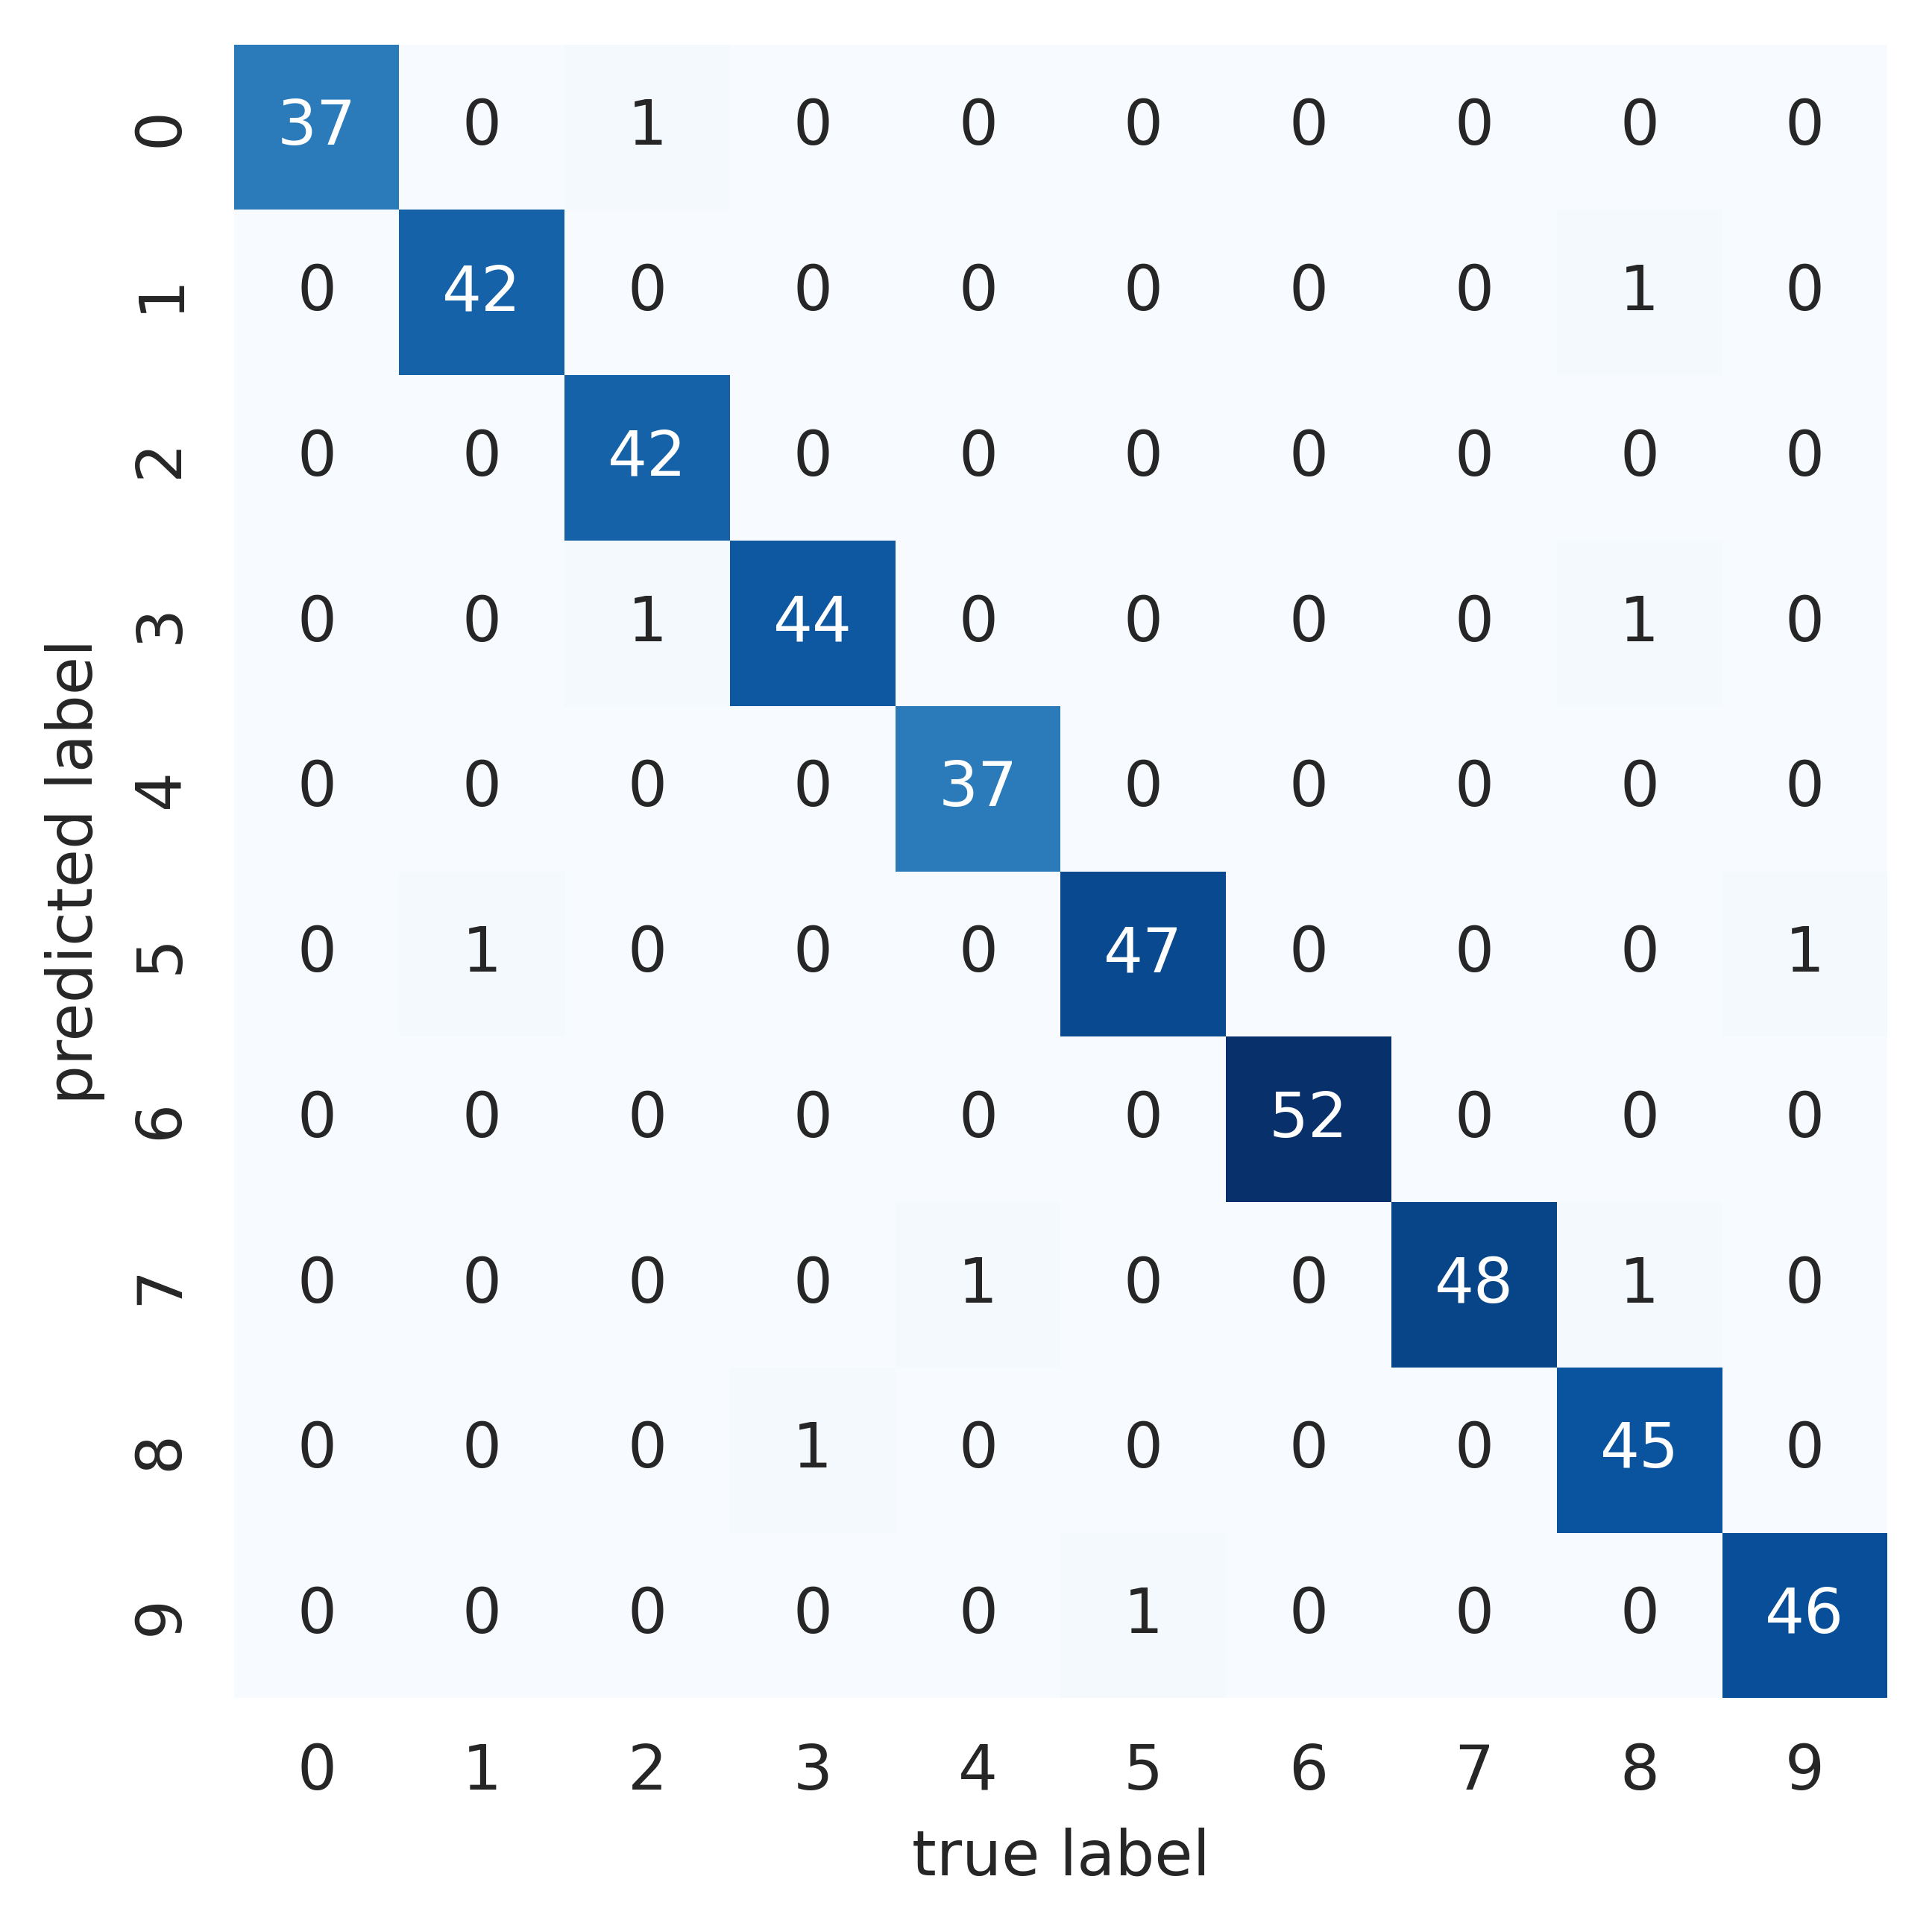

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
mat = confusion_matrix(ytest, ypred)
sns.heatmap(mat.T, square=True, annot=True, fmt='d',
            cbar=False, cmap='Blues')
plt.xlabel('true label')
plt.ylabel('predicted label');

Encontramos que un bosque aleatorio simple y sin ajustar resulta en una clasificación bastante precisa de los datos de dígitos.

## Resumen

Este capítulo proporcionó una breve introducción al concepto de estimadores en conjunto, y en particular al random forest, un conjunto de árboles de decisión aleatorios.
Los random forests son un método poderoso con varias ventajas:

- Tanto el entrenamiento como la predicción son muy rápidos, debido a la simplicidad de los árboles de decisión subyacentes. Además, ambas tareas pueden paralelizarse de manera sencilla, ya que los árboles individuales son entidades completamente independientes.
- La existencia de múltiples árboles permite una clasificación probabilística: un voto mayoritario entre los estimadores proporciona una estimación de la probabilidad (accesible en Scikit-Learn con el método `predict_proba`).
- El modelo no paramétrico es extremadamente flexible y, por lo tanto, puede desempeñarse bien en tareas en las que otros estimadores tienen un bajo ajuste.

Una desventaja principal de los bosques aleatorios es que los resultados no son fácilmente interpretables: es decir, si deseas sacar conclusiones sobre el *significado* del modelo de clasificación, los bosques aleatorios pueden no ser la mejor opción.
